In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

# Read Datasets

In [2]:
data = pd.read_csv('dataset/All_Flows.csv')

In [3]:
data['label'].value_counts()

benign                     783574
port_scan                  159614
ddos                        45480
dos_hulk                    14108
dos_goldeneye                7574
dos_slowhttptest             4217
ftp_patator                  3993
dos_slowloris                3895
ssh_patator                  2979
infiltration_dropbox_p2      2009
webattack_bruteforce         1365
botnet                       1226
webattack_xss                 679
webattack_sqli                 12
infiltration_meta               4
infiltration_dropbox_p1         1
heartbleed                      1
infiltration_cooldisk           1
Name: label, dtype: int64

In [4]:
df = data.copy()

- Grouping similar attacks

In [5]:
def group_label(label: str):
    if 'infiltration' in label:
        return 'infiltration'
    elif 'webattack' in label:
        return 'web attack'
    else:
        return label
    
data['label'] = data['label'].apply(group_label)

In [6]:
data['label'].value_counts()

benign              783574
port_scan           159614
ddos                 45480
dos_hulk             14108
dos_goldeneye         7574
dos_slowhttptest      4217
ftp_patator           3993
dos_slowloris         3895
ssh_patator           2979
web attack            2056
infiltration          2015
botnet                1226
heartbleed               1
Name: label, dtype: int64

# Data Exploration

In [7]:
# df = pd.concat([df_benign, df_botnet, df_portscan, df_ddos], axis=0)
# Remove Empty FLOW IDS
mask = ~df[['sport', 'src_ip', 'dst_port', 'dst_ip']].isnull().any(axis=1)

# Apply the mask to filter rows
df = df[mask]

- Flow id needs to be unique? => Not necessarily, same machine can be used in different attacks

In [8]:
# Create Flow ID Column
df['sport'] = df['sport'].astype(int).astype(str)
df['dst_port'] = df['dst_port'].astype(int).astype(str)
df['flow_id'] = df['src_ip'] + '-' + df['dst_ip'] + '-' + df['sport'] + '-' + df['dst_port']

In [9]:
# Count numple of flow ids duplicates
df['count_flow_id'] = df.groupby(['flow_id', 'label']).transform('count')['sport']

Checking if all the duplicates are from benign traffic or not

In [10]:
tmp = df[['flow_id', 'count_flow_id','label']].drop_duplicates().sort_values(by='count_flow_id', ascending=False)[['count_flow_id', 'label']]
tmp[tmp['count_flow_id'] > 1].value_counts()

count_flow_id  label 
2              benign    54496
3              benign    25121
4              benign    12090
5              benign     4160
6              benign     1111
14             benign      714
13             benign      698
15             benign      421
12             benign      407
7              benign      233
11             benign      138
16             benign      111
10             benign       35
17             benign       27
8              benign       26
9              benign       15
dtype: int64

- `flow_duration`

In [11]:
data['flow_duration'].describe()

count    1.030732e+06
mean     5.457184e+02
std      2.682853e+03
min      0.000000e+00
25%      1.810000e-04
50%      1.349955e-01
75%      1.518431e+01
max      2.904384e+04
Name: flow_duration, dtype: float64

In [12]:
data_benign = data[data['label'] == 'benign'].copy()

In [13]:
# # Calculate the 10th and 90th percentile values => For easy visualization
# q10 = data_benign['flow_duration'].quantile(0.10)
# q90 = data_benign['flow_duration'].quantile(0.90)

# filtered_df = data_benign[(data_benign['flow_duration'] >= q10) & (df['flow_duration'] <= q90)].copy()

In [14]:
# sns.boxplot(x='label', y='flow_duration', data=data_benign, showfliers=False, showmeans=False);

Analyzing flow duration distribution across all attacks

In [15]:
data['flow_duration_log'] = np.log10(data['flow_duration']+1)

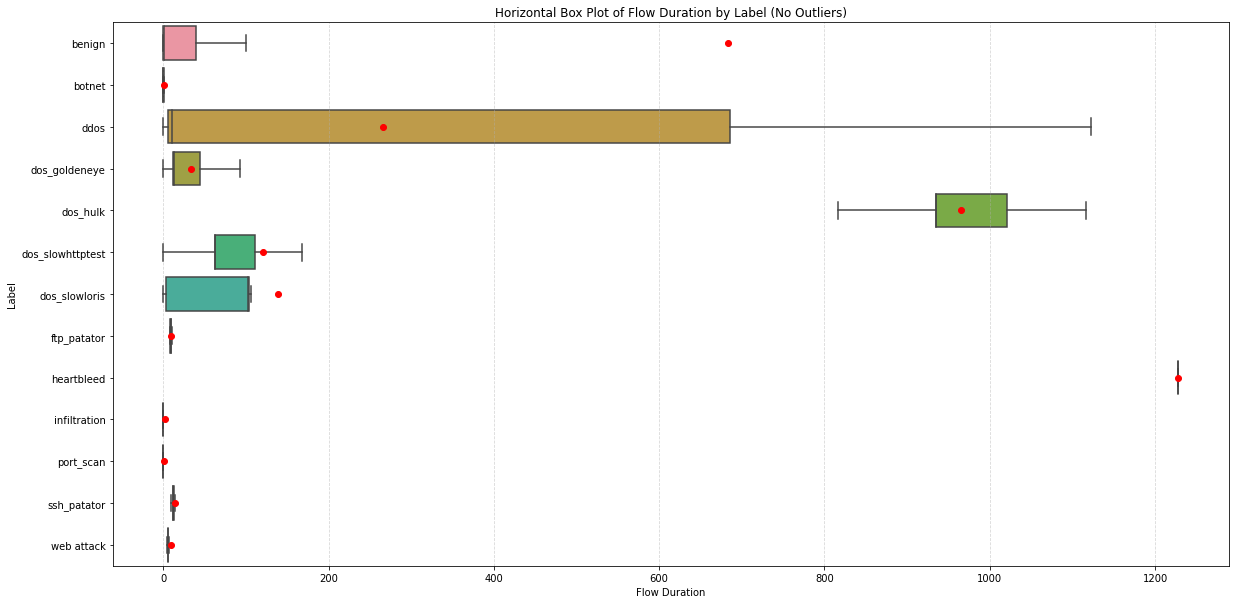

In [16]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Analyzing flow duration distribution across attacks with small flow duration

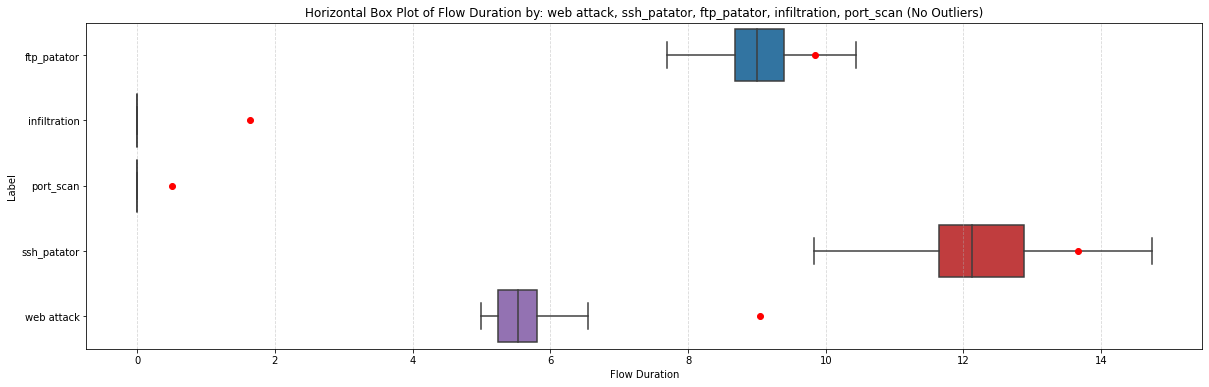

In [17]:
plt.figure(figsize=(20, 6))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration', data=data[data['label'].isin(['web attack', 'ssh_patator', 'ftp_patator', 'infiltration', 'port_scan'])],
            showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by: web attack, ssh_patator, ftp_patator, infiltration, port_scan (No Outliers)')

plt.show()

Log-Based

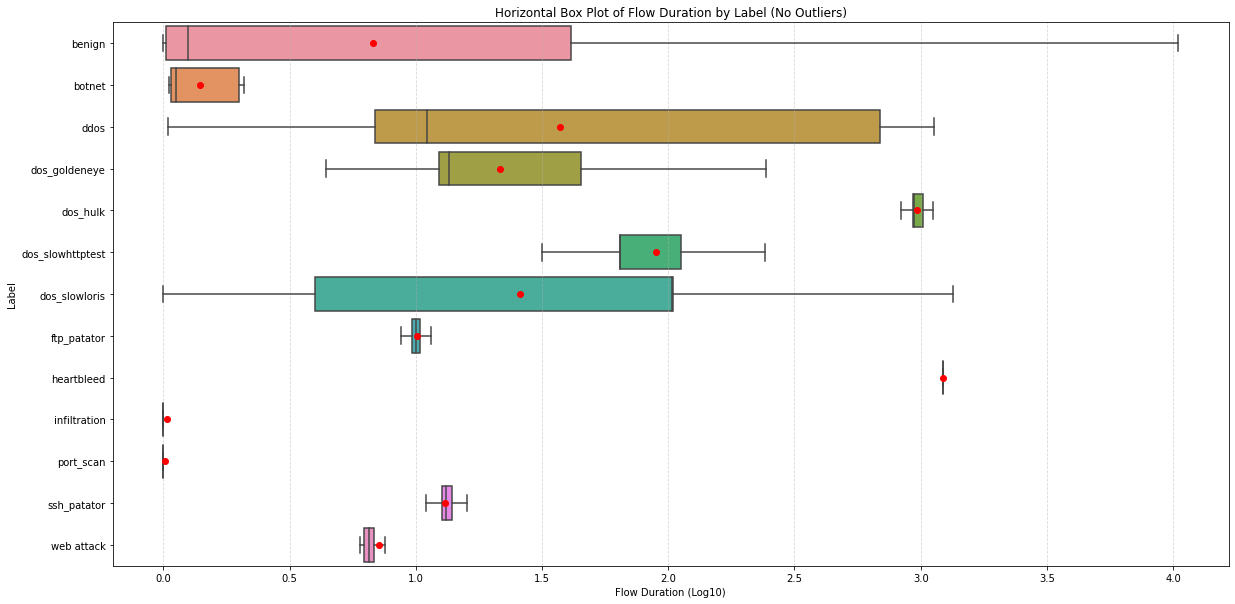

In [18]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration (Log10)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [19]:
labels = data['label'].unique()

In [20]:
grouped = data.groupby('label')['flow_duration']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [21]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [22]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
7,benign,heartbleed,-0.177946,0.858765
19,botnet,infiltration,-0.759359,0.447693
20,botnet,port_scan,-0.073260,0.941600
28,ddos,heartbleed,-2.711920,0.006692
50,dos_slowhttptest,dos_slowloris,-3.367043,0.000763
67,ftp_patator,web attack,0.759156,0.447789
72,infiltration,port_scan,2.553605,0.010662
77,ssh_patator,web attack,2.586767,0.009716


=> **Conclusion**: The statistical analysis using a t-test indicates that there is a significant difference in the distribution of flow durations between different attacks. This finding suggests that flow duration can serve as a meaningful indicator or predictor of attack events.

In the above table we can observe some exceptions: (dos_slowhttptest, dos_slowloris), (ssh_patator, web attack)

`total_packets`

In [23]:
data['total_packets'] = data['total_fwd_packets'] + data['total_bwd_packets']
data['total_packets_log'] = np.log10(data['total_packets']+1)

In [24]:
data['total_packets'].describe()

count    1.030732e+06
mean     4.019371e+01
std      5.651728e+03
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.900000e+01
max      2.458132e+06
Name: total_packets, dtype: float64

Analyzing total_packets distribution. Removing Heartbleed from analyzsis (only one sample)

In [25]:
list(set(data['label']))

['web attack',
 'infiltration',
 'botnet',
 'benign',
 'ssh_patator',
 'dos_slowloris',
 'dos_slowhttptest',
 'ftp_patator',
 'heartbleed',
 'dos_goldeneye',
 'port_scan',
 'dos_hulk',
 'ddos']

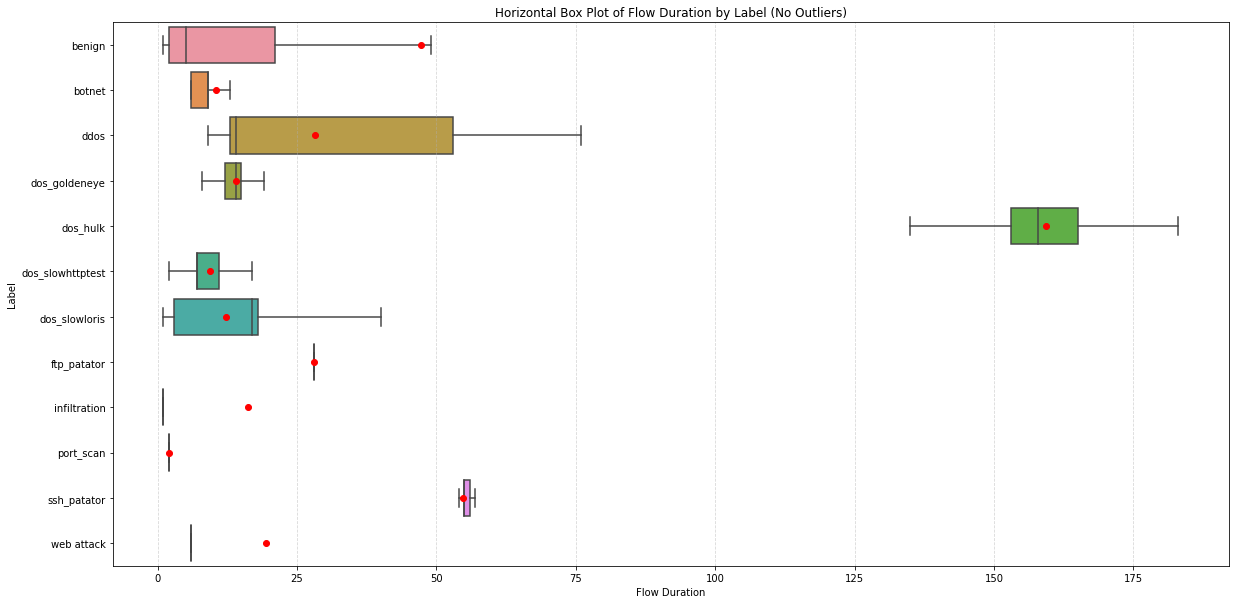

In [26]:
col_analysis = ['dos_goldeneye', 'port_scan', 'botnet', 'ssh_patator', 'benign', 'dos_slowloris', 'ftp_patator', 'ddos', 'web attack',
          'dos_slowhttptest', 'infiltration', 'dos_hulk']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_packets', data=data[data['label'].isin(col_analysis)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

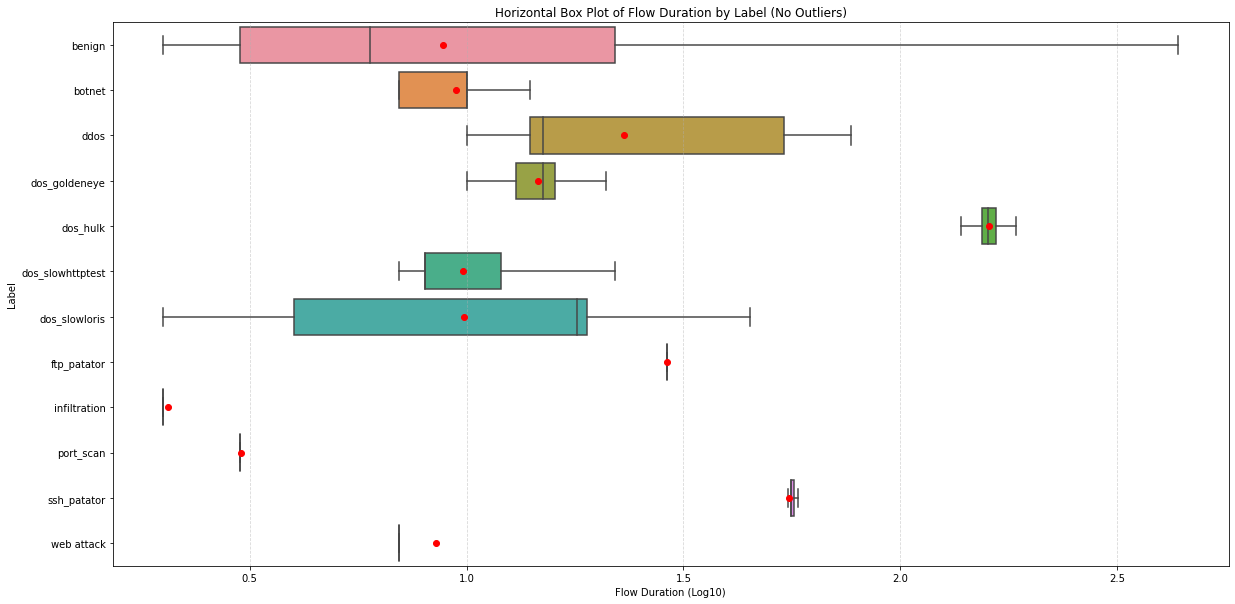

In [27]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_packets_log', data=data[data['label'].isin(col_analysis)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration (Log10)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [28]:
labels = data['label'].unique()

In [29]:
grouped = data.groupby('label')['total_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [51]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [31]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,botnet,0.198462,0.842683
1,benign,ddos,0.626145,0.531220
2,benign,dos_goldeneye,0.445360,0.656060
3,benign,dos_hulk,-2.054056,0.039971
4,benign,dos_slowhttptest,0.378528,0.705039
5,benign,dos_slowloris,0.336694,0.736348
6,benign,ftp_patator,0.187519,0.851253
8,benign,infiltration,0.214722,0.829984
9,benign,port_scan,2.783984,0.005370
10,benign,ssh_patator,-0.064295,0.948735


=> **Conclusion**: 
- Benign Traffic vs. Attacks:

The distribution of 'total_packets' does not exhibit statistically significant differences between benign traffic and the aggregate of all attack types. This suggests that 'total_packets' alone may not reliably differentiate benign traffic from attacks.
- Differentiation Among Attack Types:

However, 'total_packets' demonstrates statistically significant differences among specific attack types, including DDoS, dos_goldeneye, dos_hulk, dos_slowhttptest, and dos_slowloris. Therefore, 'total_packets' serves as a useful feature for distinguishing between these specific types of attacks.

- `inter_arrival_mean`

In [35]:
data['inter_arrival_mean'].describe()

count    1.025168e+06
mean     1.005036e+02
std      5.912327e+02
min     -1.300000e-05
25%      1.830000e-04
50%      3.987454e-02
75%      1.089997e+00
max      9.537357e+03
Name: inter_arrival_mean, dtype: float64

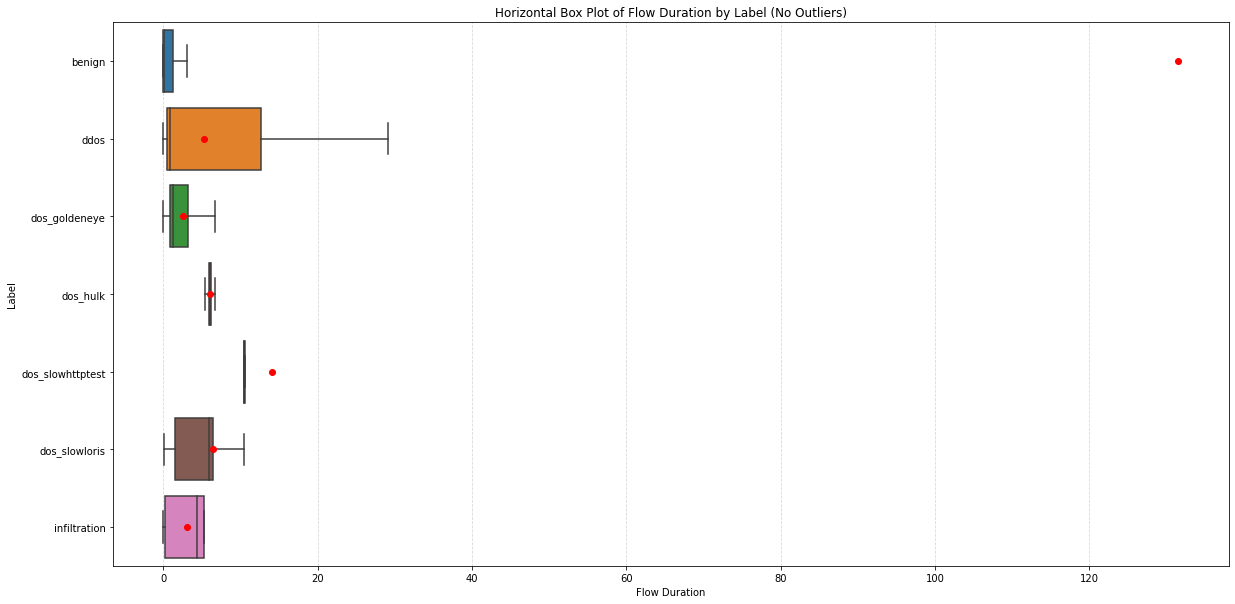

In [47]:
col_analysis = ['benign', 'ddos','dos_slowloris','dos_slowhttptest', 'dos_hulk', 'dos_goldeneye', 'infiltration']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='inter_arrival_mean', data=data[data['label'].isin(col_analysis)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

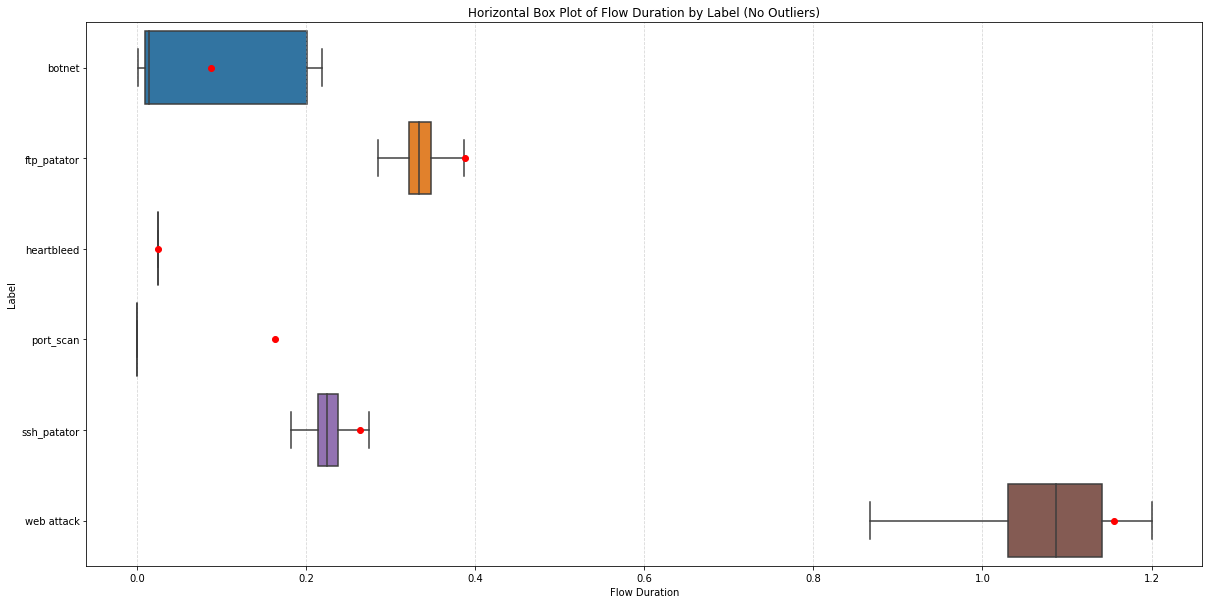

In [46]:
col_analysis = col_analysis = ['web attack', 'ssh_patator', 'port_scan', 'heartbleed', 'ftp_patator', 'botnet']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='inter_arrival_mean', data=data[data['label'].isin(col_analysis)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [52]:
labels = data['label'].unique()

In [53]:
grouped = data.groupby('label')['inter_arrival_mean']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [54]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [55]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
18,botnet,heartbleed,0.665862,0.505625
28,ddos,heartbleed,0.816957,0.413957
37,dos_goldeneye,heartbleed,0.931356,0.351699
52,dos_slowhttptest,heartbleed,1.069153,0.285062
63,ftp_patator,heartbleed,0.354910,0.722675
70,heartbleed,ssh_patator,-0.174296,0.861644
71,heartbleed,web attack,-0.269398,0.787651


=> **Conclusion**: 


- Differentiation Between Attacks and Non-Attacks:

Inter-arrival time demonstrates statistically significant differences between attacks and non-attacks. This suggests that inter-arrival time is a valuable indicator for distinguishing malicious traffic from benign traffic.

- Differentiation Among Attack Types:

Inter-arrival time also shows statistically significant differences among most attack types. However, the result is not statistically significant for the 'heartbleed' attack. This exception is disregarded due to the limited sample size (only 1 sample for 'heartbleed').


 # STOP HERE FOR NOW

In [73]:
data['total_packets'] = data['total_bwd_packets'] + data['total_fwd_packets']

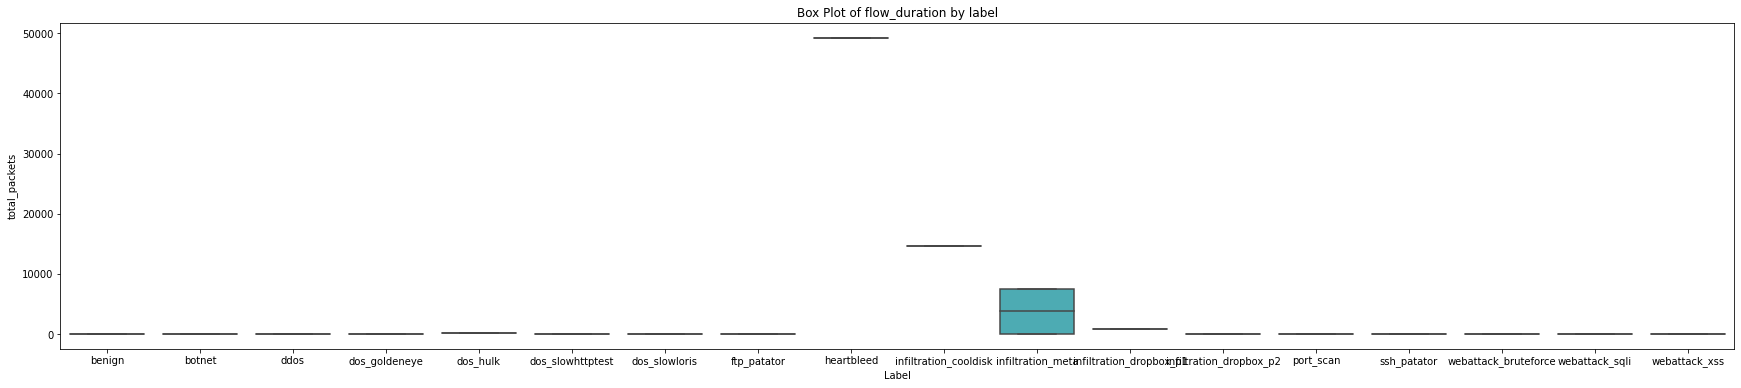

In [55]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='total_packets', data=data, showfliers=False)
plt.title('Box Plot of flow_duration by label')
plt.xlabel('Label')
plt.ylabel('total_packets')
plt.show()

Box plots analysis

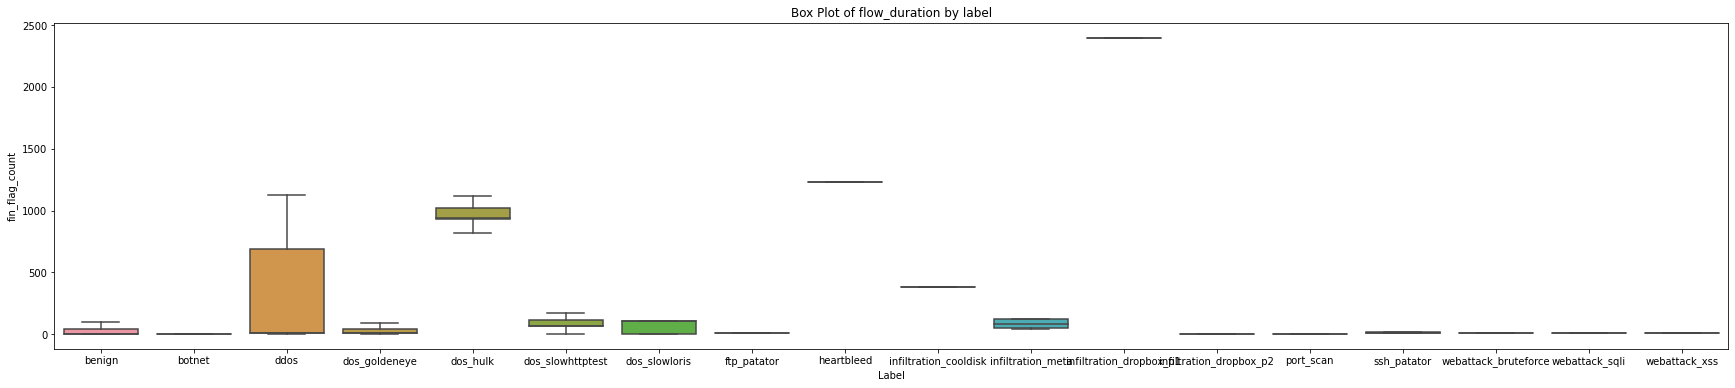

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='flow_duration', data=df, showfliers=False)
plt.title('Box Plot of flow_duration by label')
plt.xlabel('Label')
plt.ylabel('fin_flag_count')
plt.show()

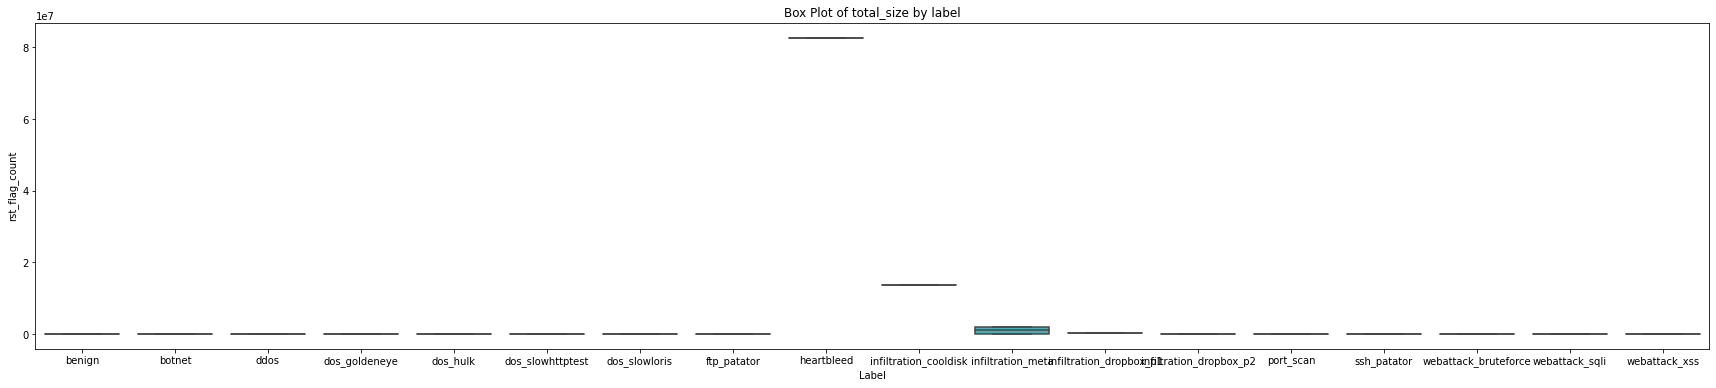

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='total_size', data=df, showfliers=False)
plt.title('Box Plot of total_size by label')
plt.xlabel('Label')
plt.ylabel('rst_flag_count')
plt.show()

- Handling NaNs

In [10]:
df.isnull().sum()*100/df.shape[0]

sport                      0.000000
src_ip                     0.000000
dst_port                   0.000000
dst_ip                     0.000000
protocol                   0.000000
first_timestamp            0.000000
last_timestamp             0.000000
flow_duration              0.000000
total_size                 0.000000
avg_size                   0.000000
std_size                   0.000000
inter_arrival_mean         0.538682
inter_arrival_std          0.538682
total_fwd_packets          0.000000
first_timestamp_fwd        0.000000
last_timestamp_fwd         0.000000
fwd_flow_duration          0.000000
total_fwd_pkt_size         0.000000
avg_fwd_pkt_size           0.000000
std_fwd_pkt_size           0.000000
inter_arrival_mean_fwd    46.822967
inter_arrival_std_fwd     46.822967
total_bwd_packets          0.000000
first_timestamp_bwd        1.211550
last_timestamp_bwd         1.211550
bwd_flow_duration          1.211550
total_bwd_pkt_size         0.000000
avg_bwd_pkt_size           1

In [11]:
df_benign = df[df['label'] == 'benign'].copy()
df_benign.isnull().sum()*100/df_benign.shape[0]

sport                      0.000000
src_ip                     0.000000
dst_port                   0.000000
dst_ip                     0.000000
protocol                   0.000000
first_timestamp            0.000000
last_timestamp             0.000000
flow_duration              0.000000
total_size                 0.000000
avg_size                   0.000000
std_size                   0.000000
inter_arrival_mean         0.428842
inter_arrival_std          0.428842
total_fwd_packets          0.000000
first_timestamp_fwd        0.000000
last_timestamp_fwd         0.000000
fwd_flow_duration          0.000000
total_fwd_pkt_size         0.000000
avg_fwd_pkt_size           0.000000
std_fwd_pkt_size           0.000000
inter_arrival_mean_fwd    41.128977
inter_arrival_std_fwd     41.128977
total_bwd_packets          0.000000
first_timestamp_bwd        0.747537
last_timestamp_bwd         0.747537
bwd_flow_duration          0.747537
total_bwd_pkt_size         0.000000
avg_bwd_pkt_size           0

In [190]:
# # Get only the numeric columns
# numeric_cols = df.select_dtypes(include=['number'])

# # Fill NaN values with the mean of each numeric column
# df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

- Convert datetime features -> get the Unix timestamp.

In [12]:
df['first_timestamp'].value_counts()

55:28.8    1087
55:56.4    1062
55:14.3    1050
55:34.0    1045
55:45.9    1043
           ... 
47:54.7       1
41:50.0       1
16:30.4       1
52:23.3       1
35:12.1       1
Name: first_timestamp, Length: 35897, dtype: int64

In [192]:
# df['first_timestamp'] = pd.to_datetime(df['first_timestamp']).astype(int) / 10**9
# df['first_timestamp_fwd'] = pd.to_datetime(df['first_timestamp_fwd']).astype(int) / 10**9


# df['last_timestamp_bwd'] = pd.to_datetime(df['last_timestamp_bwd']).astype(int) / 10**9

# df['last_timestamp'] = pd.to_datetime(df['last_timestamp']).astype(int) / 10**9

# df['first_timestamp_bwd'] = pd.to_datetime(df['first_timestamp_bwd']).astype(int) / 10**9

# df['last_timestamp_fwd'] = pd.to_datetime(df['last_timestamp_fwd']).astype(int) / 10**9


# Dataframe - Rescaled Proportions

In [193]:
original_total = 2187304

In [194]:
benign = 1807787
ddos = 320269
portscan = 57305
botnet = 1943

In [195]:
print('Benign %: ', benign/original_total)
print('Ddos %: ', ddos/original_total)
print('PortScan %: ', portscan/original_total)
print('Botnet %: ', botnet/original_total)

Benign %:  0.8264909678764361
Ddos %:  0.14642180510802338
PortScan %:  0.02619891885170054
Botnet %:  0.0008883081638400515


In [196]:
benign_count = df['label'].value_counts().benign
ddos_count = int(np.floor(df['label'].value_counts().benign*ddos/original_total))
portscan_count = int(np.floor(df['label'].value_counts().benign*portscan/original_total))
botnet_count = int(np.floor(df['label'].value_counts().benign*botnet/original_total))

In [14]:
df_resampled = pd.concat([
    df[df['label'] == 'benign'],
    df[df['label'] == 'ddos'].sample(ddos_count, random_state=42),
    df[df['label'] == 'port_scan'].sample(portscan_count, random_state=42),
    df[df['label'] == 'botnet'].sample(botnet_count, random_state=42)
])

In [15]:
print(df_resampled['label'].value_counts())
# Compute proportions
proportions = df_resampled['label'].value_counts()*100 / len(df_resampled)

# Display proportions
print(proportions)

benign       4802
ddos          703
port_scan     125
botnet          4
Name: label, dtype: int64
benign       85.232517
ddos         12.477813
port_scan     2.218672
botnet        0.070998
Name: label, dtype: float64


# Split dataset

In [12]:
# df = df_resampled

In [13]:
df.head()

,sport,src_ip,dst_port,dst_ip,protocol,first_timestamp,last_timestamp,flow_duration,total_size,avg_size,std_size,inter_arrival_mean,inter_arrival_std,total_fwd_packets,first_timestamp_fwd,last_timestamp_fwd,fwd_flow_duration,total_fwd_pkt_size,avg_fwd_pkt_size,std_fwd_pkt_size,inter_arrival_mean_fwd,inter_arrival_std_fwd,total_bwd_packets,first_timestamp_bwd,last_timestamp_bwd,bwd_flow_duration,total_bwd_pkt_size,avg_bwd_pkt_size,std_bwd_pkt_size,inter_arrival_mean_bwd,inter_arrival_std_bwd,syn_flag_count,fin_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwr_flag_count,ece_flag_count,label,flow_id,count_flow_id
0,80,8.254.250.126,49188,192.168.10.5,6,55:58.6,55:58.6,0.000000,40,40.0,0.000,NaN,NaN,1,55:58.6,55:58.6,0.000000,40,40.000,0.000,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,benign,8.254.250.126-192.168.10.5-80-49188,1
1,80,8.253.185.121,49486,192.168.10.14,6,56:22.3,56:22.3,0.000000,40,40.0,0.000,NaN,NaN,1,56:22.3,56:22.3,0.000000,40,40.000,0.000,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,benign,8.253.185.121-192.168.10.14-80-49486,1
3,60372,192.168.10.9,5355,224.0.0.252,17,56:37.6,56:37.7,0.098631,112,56.0,0.000,0.098631,0.000000,2,56:37.6,56:37.7,0.098631,112,56.000,0.000,0.098631,0.000000,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,benign,192.168.10.9-224.0.0.252-60372-5355,1
4,137,192.168.10.9,137,192.168.10.3,17,56:37.9,53:36.4,28618.462310,17202,91.5,4.936,153.039905,397.914943,93,56:37.9,53:36.4,28618.462210,8712,93.677,6.034,311.070241,522.185092,95,1.499083e+09,1.499112e+09,28618.46208,8490,89.368,1.841,304.451724,518.546738,0,0,0,0,0,0,0,0,benign,192.168.10.9-192.168.10.3-137-137,16
5,63683,192.168.10.9,53,192.168.10.3,17,56:37.9,24:43.3,16085.431880,430,107.5,35.146,5361.810628,7582.536591,2,56:37.9,24:43.0,16085.137000,169,84.500,24.500,16085.137000,0.000000,2,1.499083e+09,1.499099e+09,16085.43160,261,130.500,28.500,16085.431600,0.000000,0,0,0,0,0,0,0,0,benign,192.168.10.9-192.168.10.3-63683-53,2


In [13]:
# Removing non-numerical features
features = list(set(df.columns) -\
    set(['label', 'flow_id', 'src_ip', 'dst_port', 'dst_ip', 'sport', 'pkt_lens', 'fwd_inter_arrival_times', 'fwd_arrival_times',
         'bwd_arrival_times', 'arrival_times', 'bwd_pkt_lens', 'inter_arrival_times', 'fwd_pkt_lens', 'bwd_inter_arrival_times']) -\
              set(['first_timestamp', 'last_timestamp', 'first_timestamp_fwd', 'last_timestamp_fwd', 'first_timestamp_bwd', 'last_timestamp_bwd']))
label = ['label']

In [14]:
features

['cwr_flag_count',
 'avg_bwd_pkt_size',
 'inter_arrival_mean',
 'inter_arrival_std_bwd',
 'urg_flag_count',
 'count_flow_id',
 'inter_arrival_std_fwd',
 'inter_arrival_mean_fwd',
 'std_fwd_pkt_size',
 'ack_flag_count',
 'std_bwd_pkt_size',
 'psh_flag_count',
 'bwd_flow_duration',
 'fin_flag_count',
 'rst_flag_count',
 'protocol',
 'total_bwd_pkt_size',
 'inter_arrival_mean_bwd',
 'flow_duration',
 'std_size',
 'avg_fwd_pkt_size',
 'total_fwd_packets',
 'inter_arrival_std',
 'avg_size',
 'total_bwd_packets',
 'total_fwd_pkt_size',
 'syn_flag_count',
 'total_size',
 'ece_flag_count',
 'fwd_flow_duration']

# Split dataset

In [15]:
# # COLUMN len_per_sec has INF

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df['len_per_sec'].fillna(df['len_per_sec'].mean(), inplace=True)

In [17]:
X.isnull().sum()

NameError: name 'X' is not defined

In [27]:


# X = df[features]
# # X = df[['fin_flag_count', 'rst_flag_count']]
# y = df['label']

# Droping NaN
X = df[ features+ ['label']].dropna(how='any')
y = X[label]
X = X[features]



label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Binarize the labels
y_bin = label_binarize(y_encoded, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
X.shape[0]

516954

# Model

In [16]:
pd.set_option('display.max_columns', None)

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from itertools import cycle

- Logistic Regression

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

NameError: name 'train_test_split' is not defined

In [23]:
# Create the classifier
clf = OneVsRestClassifier(Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))]))

In [31]:
# Train the classifier
clf.fit(X_train, y_train)

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(


OneVsRestClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('classifier',
                                               LogisticRegression(max_iter=10000))]))

In [32]:
y_score = clf.predict_proba(X_test)

In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

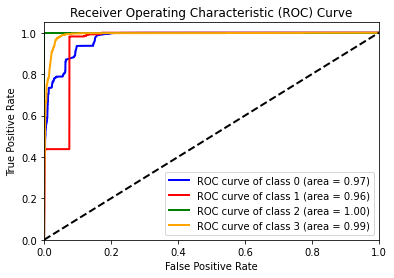

In [34]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 8 is present in all training examples.
  warnings.warn(
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 8 is present in all training examples.
  warnings.warn(
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 11 is present in all training examples.
  warnings.warn(
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label n

0.95 accuracy with a standard deviation of 0.00


- XGB

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [32]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [38]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    objective='multi:softmax')#, num_class=len(set(y_train)))

In [36]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17}

In [34]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], got [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17]

In [81]:
xgb_clf.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17}

In [612]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1445
           1       0.99      0.38      0.55       360
           2       0.94      0.99      0.97      2572
           3       0.99      0.99      0.99      4834

    accuracy                           0.95      9211
   macro avg       0.94      0.81      0.84      9211
weighted avg       0.95      0.95      0.95      9211



In [613]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

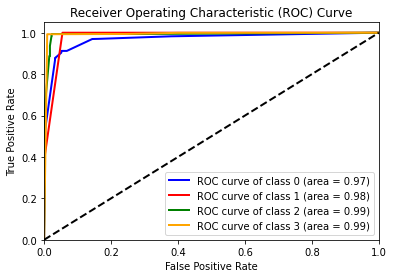

In [614]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

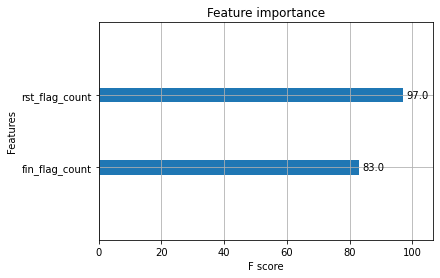

In [615]:
# Plot feature importance
xgb.plot_importance(xgb_clf)
plt.show()

In [536]:
scores = cross_val_score(xgb_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


In [537]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_test, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

Element Counts:
0: 1445
1: 360
2: 2572
3: 4834


In [538]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_pred, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

Element Counts:
0: 1442
1: 366
2: 2575
3: 4828


In [539]:
# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9980458147866681


- RF

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [541]:
feature_names = list(X_train.columns)

In [542]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

In [543]:
# Initialize Random Forest classifier for multiclass classification
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [544]:
# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

y_pred_prob = rf_clf.predict_proba(X_test)

In [545]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1445
           1       1.00      1.00      1.00       360
           2       1.00      1.00      1.00      2572
           3       1.00      1.00      1.00      4834

    accuracy                           1.00      9211
   macro avg       1.00      1.00      1.00      9211
weighted avg       1.00      1.00      1.00      9211

Accuracy: 1.0


In [546]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

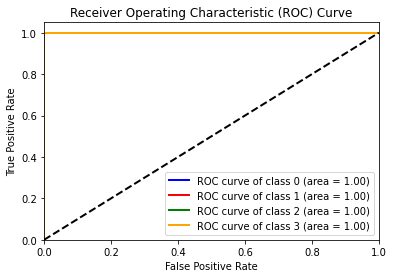

In [547]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

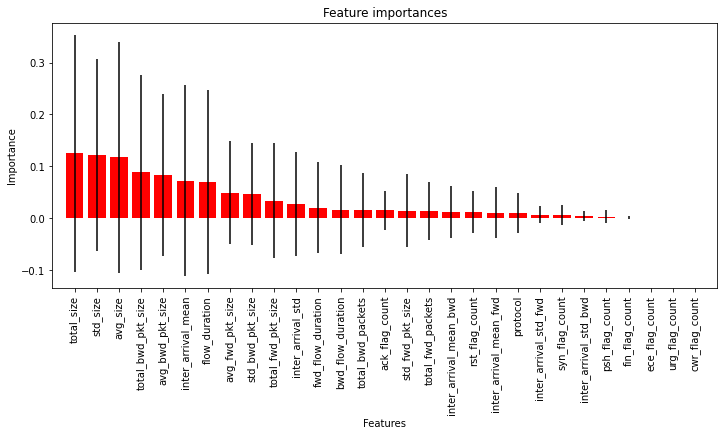

In [548]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)  # Replace with original feature names and rotate x-axis labels by 45 degrees
plt.xlim([-1, X.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout(pad=0.5)
plt.show()

In [549]:
scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00
